In [1]:
import cv2 as cv
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import pandas as pd

In [2]:
def plot_image(img, cmap='gray'):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img, cmap=cmap)
    plt.show()

In [19]:
df = pd.read_pickle('data/df.pkl')
final_df = pd.read_csv('data/final_df.csv')

In [20]:
from torchvision.models import resnet18
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import torch

In [21]:
class ResNetMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # define model and loss
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # this decorator automatically handles moving your tensors to GPU if required
    def forward(self, x):
        return self.model(x)
  
    def training_step(self, batch, batch_no):
        # implement single training step
        x, y = batch
        logits = self(x)
        return logits


In [22]:
model = ResNetMNIST()
model.load_state_dict(torch.load('saved_model.pth', map_location=torch.device('cpu')))
model.eval()

ResNetMNIST(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [23]:
df.head()

,game,P1_number,P2_number,P3_number,P4_number
0,game1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,game1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,game1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,game1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,game1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [24]:
final_df.head()

,P1_suite,P1_number,P2_suite,P2_number,P3_suite,P3_number,P4_suite,P4_number,D,game
0,S,Q,H,8,H,J,S,0,1,game1
1,S,5,S,J,C,9,D,K,1,game1
2,D,1,H,3,C,7,D,3,1,game1
3,S,1,D,J,S,4,C,4,1,game1
4,D,0,S,6,C,3,C,2,1,game1


In [43]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'J', 'K', 'Q']
pred_dict = {c1:{c2:0 for c2 in classes} for c1 in classes}

In [58]:
from tqdm import tqdm

with torch.no_grad():
    for i in tqdm(range(91)):

        data_row = df.iloc[i]
        truth_row = final_df.iloc[i]
        cards = ['P1_number', 'P2_number', 'P3_number', 'P4_number']
        
        for idx in cards:
            vector = data_row[idx]
            card = torch.tensor(vector, dtype=torch.float).unsqueeze(0).unsqueeze(0)
            truth = truth_row['P1_number']    
            out = model(card)
            _, predicted_tensor = torch.max(out.data, 1)
            predicted = predicted_tensor.item()
            
            pred_dict[str(predicted)][truth] += 1

100%|██████████| 91/91 [00:17<00:00,  5.19it/s]


In [59]:
df_pred = pd.DataFrame(pred_dict)

In [60]:
df_pred

,0,1,2,3,4,5,6,7,8,9,J,K,Q
0,0,60,0,0,0,0,0,0,0,0,0,0,0
1,0,132,0,0,0,0,0,0,0,0,0,0,0
2,0,84,0,0,0,0,0,0,0,0,0,0,0
3,0,108,0,0,0,0,0,0,0,0,0,0,0
4,0,108,0,0,0,0,0,0,0,0,0,0,0
5,0,112,0,0,0,0,0,0,0,0,0,0,0
6,0,84,0,0,0,0,0,0,0,0,0,0,0
7,0,72,0,0,0,0,0,0,0,0,0,0,0
8,0,72,0,0,0,0,0,0,0,0,0,0,0
9,0,48,0,0,0,0,0,0,0,0,0,0,0


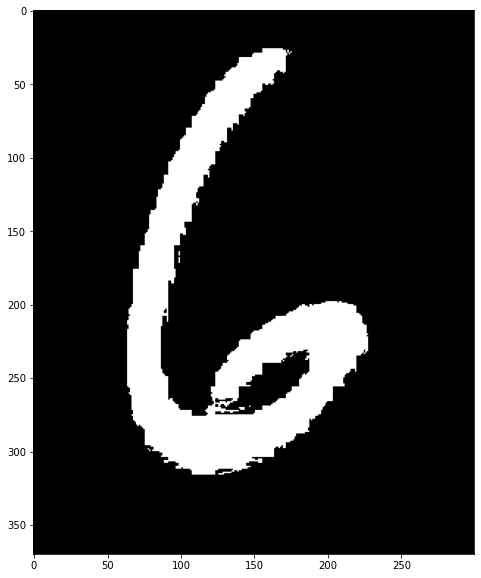

In [62]:
plot_image(vector)

In [57]:
with torch.no_grad():
    print(model(torch.tensor(vector, dtype=torch.float)))

tensor([[  2719.6819,  63984.7148,  26655.5430,  -1897.6832,   9065.0039,
         -11863.9551,  -9625.9521,   8986.6807,  17402.7793,  23983.9531]])
